In [1]:
import GAN.models as models
import GAN.cms_datasets as cms
import GAN.plotting as plotting
import GAN.preprocessing as preprocessing
import GAN.base as base

Using TensorFlow backend.


In [2]:
import GAN.utils as utils

reload(utils)

class Parameters(utils.Parameters):
    
    load_datasets=utils.param(["moriond_v9","abs(ScEta) < 1.5"])

    c_names = utils.param(['Phi','ScEta'])
    x_names = utils.param(['EtaWidth'])
#     c_names = utils.param(['Pt','ScEta','Phi','rho'])
#     x_names = utils.param(['R9','SigmaIeIe','S4','EtaWidth','PhiWidth','CovarianceIetaIphi',
#                'CovarianceIphiIphi', ])
    
    feat_transform = utils.param('gaus')
    
    g_opts=utils.param(dict(name="G_64x5",kernel_sizes=[64]*5))
    d_opts=utils.param(dict(name="D_256x5",kernel_sizes=[256]*5))
    dm_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=0.0002, decay=6e-6)))
    am_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=0.0002, decay=6e-6)))
    
    epochs=utils.param(60)
    batch_size=utils.param(4096)
    plot_every=utils.param(10)
    
    frac_data=utils.param(10)
    
class MyApp(utils.MyApp):
    classes = utils.List([Parameters])

notebook_parameters = Parameters(MyApp()).get_params()

globals().update(notebook_parameters)
notebook_parameters


{'AM_OPTS': {'opt_kwargs': {'decay': 6e-06, 'lr': 0.0002},
  'optimizer': 'RMSprop'},
 'BATCH_SIZE': 4096,
 'C_NAMES': ['Phi', 'ScEta'],
 'DM_OPTS': {'opt_kwargs': {'decay': 6e-06, 'lr': 0.0002},
  'optimizer': 'RMSprop'},
 'D_OPTS': {'kernel_sizes': [256, 256, 256, 256, 256], 'name': 'D_256x5'},
 'EPOCHS': 60,
 'FEAT_TRANSFORM': 'gaus',
 'FRAC_DATA': 10,
 'G_OPTS': {'kernel_sizes': [64, 64, 64, 64, 64], 'name': 'G_64x5'},
 'LOAD_DATASETS': ['moriond_v9', 'abs(ScEta) < 1.5'],
 'PLOT_EVERY': 10,
 'X_NAMES': ['EtaWidth']}

In [3]:
reload(cms)

data,mc = cms.load_zee(*LOAD_DATASETS)


In [4]:
data.columns

Index(['index', 'run', 'rho', 'nvtx', 'mass', 'weight', 'SigMoM', 'Pt',
       'ScEta', 'Phi', 'R9', 'S4', 'SigmaIeIe', 'EtaWidth', 'PhiWidth',
       'CovarianceIphiIphi', 'SigmaRR', 'ScEnergy', 'CovarianceIetaIphi',
       'PhoIso03', 'ChIso03', 'ChIso03worst', 'ScPreshowerEnergy', 'PhoIDMVA',
       'SigEOverE', 'run_quantile'],
      dtype='object')

In [5]:
mc.columns

Index(['index', 'run', 'rho', 'nvtx', 'mass', 'weight', 'SigMoM', 'Pt',
       'ScEta', 'Phi', 'R9', 'S4', 'SigmaIeIe', 'EtaWidth', 'PhiWidth',
       'CovarianceIphiIphi', 'SigmaRR', 'ScEnergy', 'CovarianceIetaIphi',
       'PhoIso03', 'ChIso03', 'ChIso03worst', 'ScPreshowerEnergy', 'PhoIDMVA',
       'SigEOverE'],
      dtype='object')

In [6]:
c_names = C_NAMES
x_names = X_NAMES

data_c = data[c_names]
data_x = data[x_names]

mc_c = mc[c_names]
mc_x = mc[x_names]


In [7]:
data_x.columns, data_x.shape, data_c.columns, data_c.shape

(Index(['EtaWidth'], dtype='object'),
 (17520217, 1),
 Index(['Phi', 'ScEta'], dtype='object'),
 (17520217, 2))

In [8]:
data_x.columns, data_c.columns

(Index(['EtaWidth'], dtype='object'), Index(['Phi', 'ScEta'], dtype='object'))

In [9]:
mc_x.columns, mc_c.columns

(Index(['EtaWidth'], dtype='object'), Index(['Phi', 'ScEta'], dtype='object'))

In [10]:
reload(models)

xz_shape = (1,len(x_names))
c_shape = (1,len(c_names))
gan = models.MyFFGAN( xz_shape, xz_shape, c_shape=c_shape,
                     g_opts=G_OPTS,
                     d_opts=D_OPTS,
                     dm_opts=DM_OPTS,
                     am_opts=AM_OPTS,
                    )

In [11]:
gan.get_generator()

(1, 1)


In [12]:
gan.get_discriminator()

In [13]:
gan.adversarial_compile()

In [14]:
gan.get_generator().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
G_64x5_c_input (InputLayer)      (None, 1, 2)          0                                            
____________________________________________________________________________________________________
G_64x5_input (InputLayer)        (None, 1, 1)          0                                            
____________________________________________________________________________________________________
G_64x5_all_inputs (Concatenate)  (None, 1, 3)          0           G_64x5_c_input[0][0]             
                                                                   G_64x5_input[0][0]               
____________________________________________________________________________________________________
G_64x5_up1_dense (Dense)         (None, 1, 64)         256         G_64x5_all_inputs[0][0] 

In [15]:
gan.get_discriminator().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
D_256x5_c_input (InputLayer)     (None, 1, 2)          0                                            
____________________________________________________________________________________________________
D_256x5_input (InputLayer)       (None, 1, 1)          0                                            
____________________________________________________________________________________________________
D_256x5_all_inputs (Concatenate) (None, 1, 3)          0           D_256x5_c_input[0][0]            
                                                                   D_256x5_input[0][0]              
____________________________________________________________________________________________________
D_256x5_down1_dense (Dense)      (None, 1, 256)        1024        D_256x5_all_inputs[0][0]

In [16]:
gan.am.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
G_64x5_c_input (InputLayer)      (None, 1, 2)          0                                            
____________________________________________________________________________________________________
G_64x5_input (InputLayer)        (None, 1, 1)          0                                            
____________________________________________________________________________________________________
G_64x5_all_inputs (Concatenate)  (None, 1, 3)          0           G_64x5_c_input[0][0]             
                                                                   G_64x5_input[0][0]               
____________________________________________________________________________________________________
G_64x5_up1_dense (Dense)         (None, 1, 64)         256         G_64x5_all_inputs[0][0] 

In [17]:
gan.dm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
D_256x5_c_input (InputLayer)     (None, 1, 2)          0                                            
____________________________________________________________________________________________________
D_256x5_input (InputLayer)       (None, 1, 1)          0                                            
____________________________________________________________________________________________________
D_256x5_all_inputs (Concatenate) (None, 1, 3)          0           D_256x5_c_input[0][0]            
                                                                   D_256x5_input[0][0]              
____________________________________________________________________________________________________
D_256x5_down1_dense (Dense)      (None, 1, 256)        1024        D_256x5_all_inputs[0][0]

In [18]:
gan.gan.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
G_64x5_c_input (InputLayer)      (None, 1, 2)          0                                            
____________________________________________________________________________________________________
G_64x5_input (InputLayer)        (None, 1, 1)          0                                            
____________________________________________________________________________________________________
G_64x5_all_inputs (Concatenate)  (None, 1, 3)          0           G_64x5_c_input[0][0]             
                                                                   G_64x5_input[0][0]               
____________________________________________________________________________________________________
D_256x5_c_input (InputLayer)     (None, 1, 2)          0                                   

In [19]:
gan.gan.outputs, gan.gan.inputs

([<tf.Tensor 'model_2/D_256x5_output/Sigmoid:0' shape=(?, 1) dtype=float32>,
  <tf.Tensor 'D_256x5_output/Sigmoid:0' shape=(?, 1) dtype=float32>],
 [<tf.Tensor 'G_64x5_c_input:0' shape=(?, 1, 2) dtype=float32>,
  <tf.Tensor 'G_64x5_input:0' shape=(?, 1, 1) dtype=float32>,
  <tf.Tensor 'D_256x5_c_input:0' shape=(?, 1, 2) dtype=float32>,
  <tf.Tensor 'D_256x5_input:0' shape=(?, 1, 1) dtype=float32>])

In [20]:
# plotting.plot_hists(data_x.values[:,0],mc_x.values[:,0],bins=100,range=[0,1.2])
# plt.show()
# plotting.plot_hists(data_x.values[:,1],mc_x.values[:,1],bins=100,range=[0,5e-2])

In [21]:
reload(preprocessing)

data_x,data_c,mc_x,mc_c,scaler_x,scaler_c = preprocessing.transform(data_x,data_c,mc_x,mc_c,FEAT_TRANSFORM)


In [22]:
data_x.shape,mc_x.shape

((17520217, 1, 1), (9616192, 1, 1))

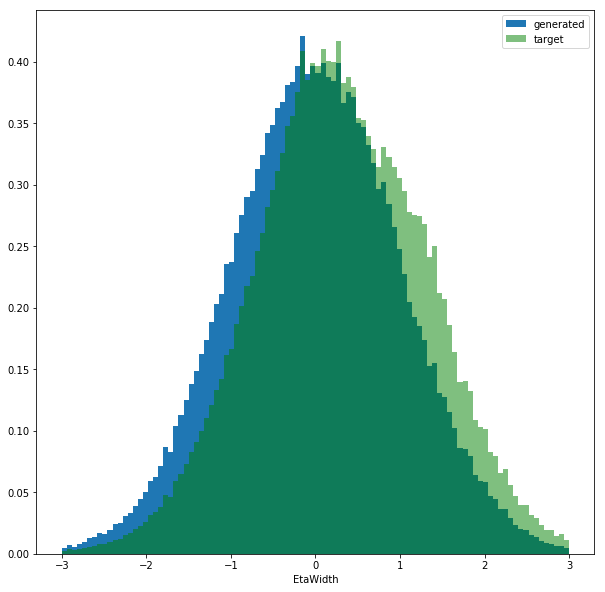

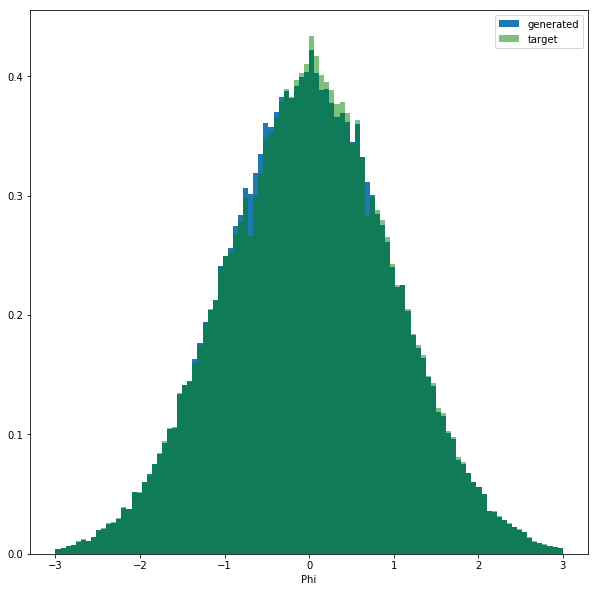

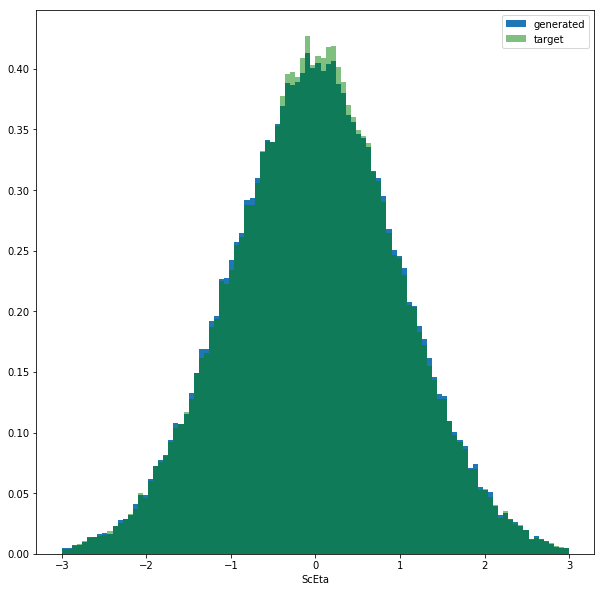

In [23]:
for ix in range(len(x_names)):
    plotting.plot_hists(data_x[:,0,ix],mc_x[:,0,ix],bins=100,range=[-3,3])
    plt.xlabel(x_names[ix])
    plt.show()

for ic in range(len(c_names)):
    plotting.plot_hists(data_c[:,0,ic],mc_c[:,0,ic],bins=100,range=[-3,3])
    plt.xlabel(c_names[ic])
    plt.show()


In [24]:
nmax = min(data_x.shape[0]//FRAC_DATA,mc_x.shape[0])

data_x_train,data_x_test,data_c_train,data_c_test = cms.train_test_split(data_x[:nmax],data_c[:nmax])
mc_x_train,mc_x_test,mc_c_train,mc_c_test = cms.train_test_split(mc_x[:nmax],mc_c[:nmax])

In [25]:
print(nmax)

1752021


/users/musella/jupyter/GAN/GAN/base.py:132: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  callbacks = [plotter], **kwargs


Epoch 1/60
1310720/1314015 [============================>.] - ETA: 0s - loss: 2.7742 - generator_loss: 1.3886 - generator_model_2_loss: 0.6945 - generator_D_256x5_output_loss: 0.6942 - discriminator_loss: 1.3855 - discriminator_model_2_loss: 0.6926 - discriminator_D_256x5_output_loss: 0.6929

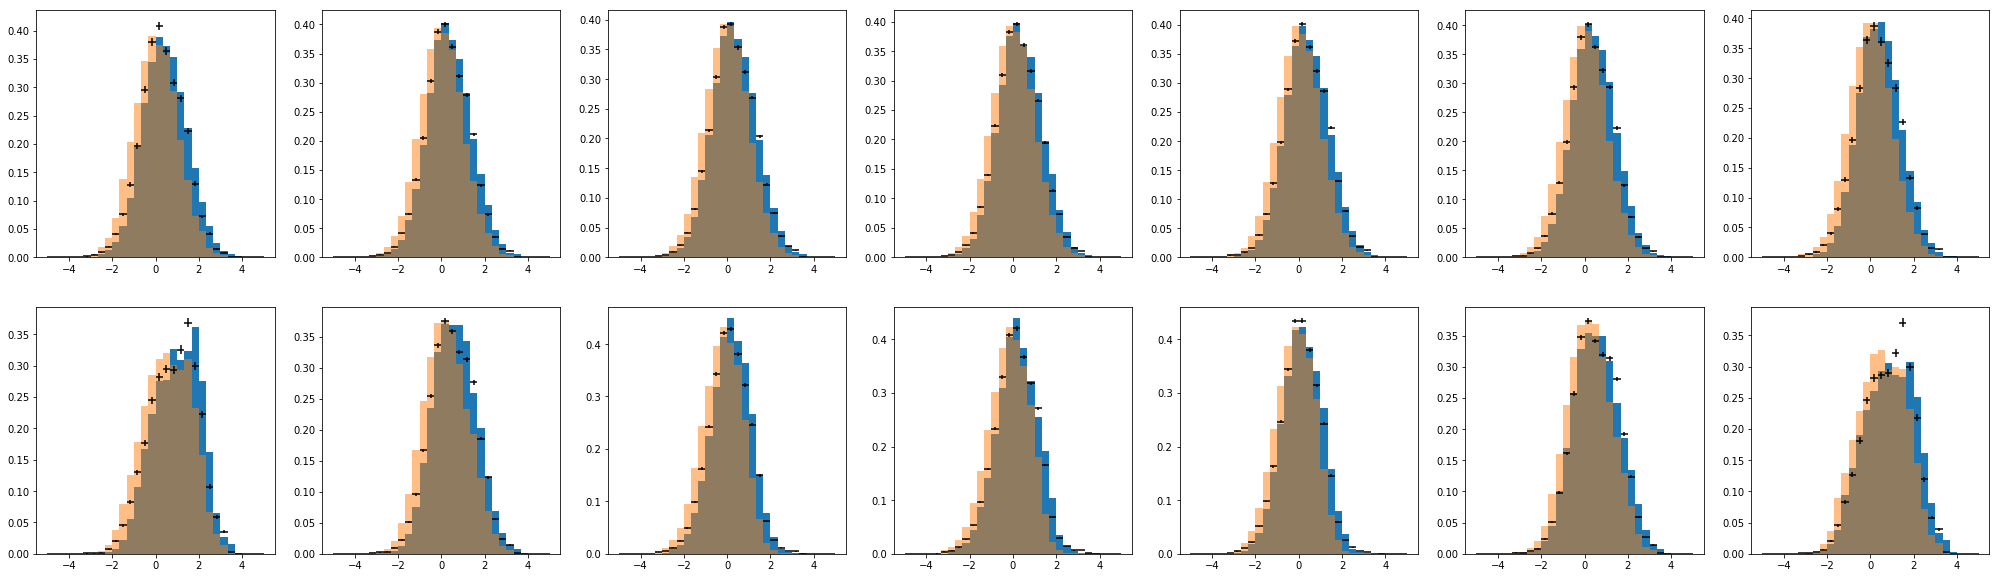

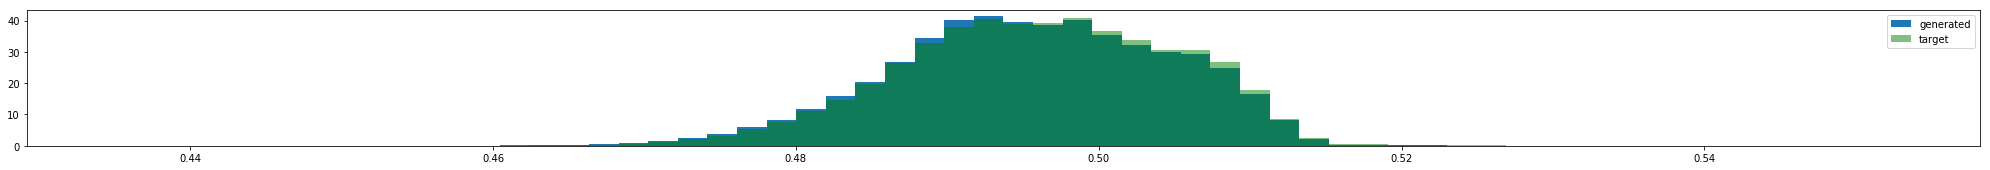

1314015/1314015 [==============================] - 69s - loss: 2.7742 - generator_loss: 1.3886 - generator_model_2_loss: 0.6945 - generator_D_256x5_output_loss: 0.6942 - discriminator_loss: 1.3855 - discriminator_model_2_loss: 0.6926 - discriminator_D_256x5_output_loss: 0.6929    
Epoch 2/60
1314015/1314015 [==============================] - 22s - loss: 2.7733 - generator_loss: 1.3872 - generator_model_2_loss: 0.6935 - generator_D_256x5_output_loss: 0.6937 - discriminator_loss: 1.3860 - discriminator_model_2_loss: 0.6931 - discriminator_D_256x5_output_loss: 0.6930    
Epoch 3/60
1314015/1314015 [==============================] - 22s - loss: 2.7733 - generator_loss: 1.3873 - generator_model_2_loss: 0.6937 - generator_D_256x5_output_loss: 0.6937 - discriminator_loss: 1.3860 - discriminator_model_2_loss: 0.6930 - discriminator_D_256x5_output_loss: 0.6930    - ETA: 8s - loss: 2.7733 - generator_loss: 1.3874 - generator_model_2_loss: 0.6936 - generator_D_256x5_output_
Epoch 4/60
1314015/131

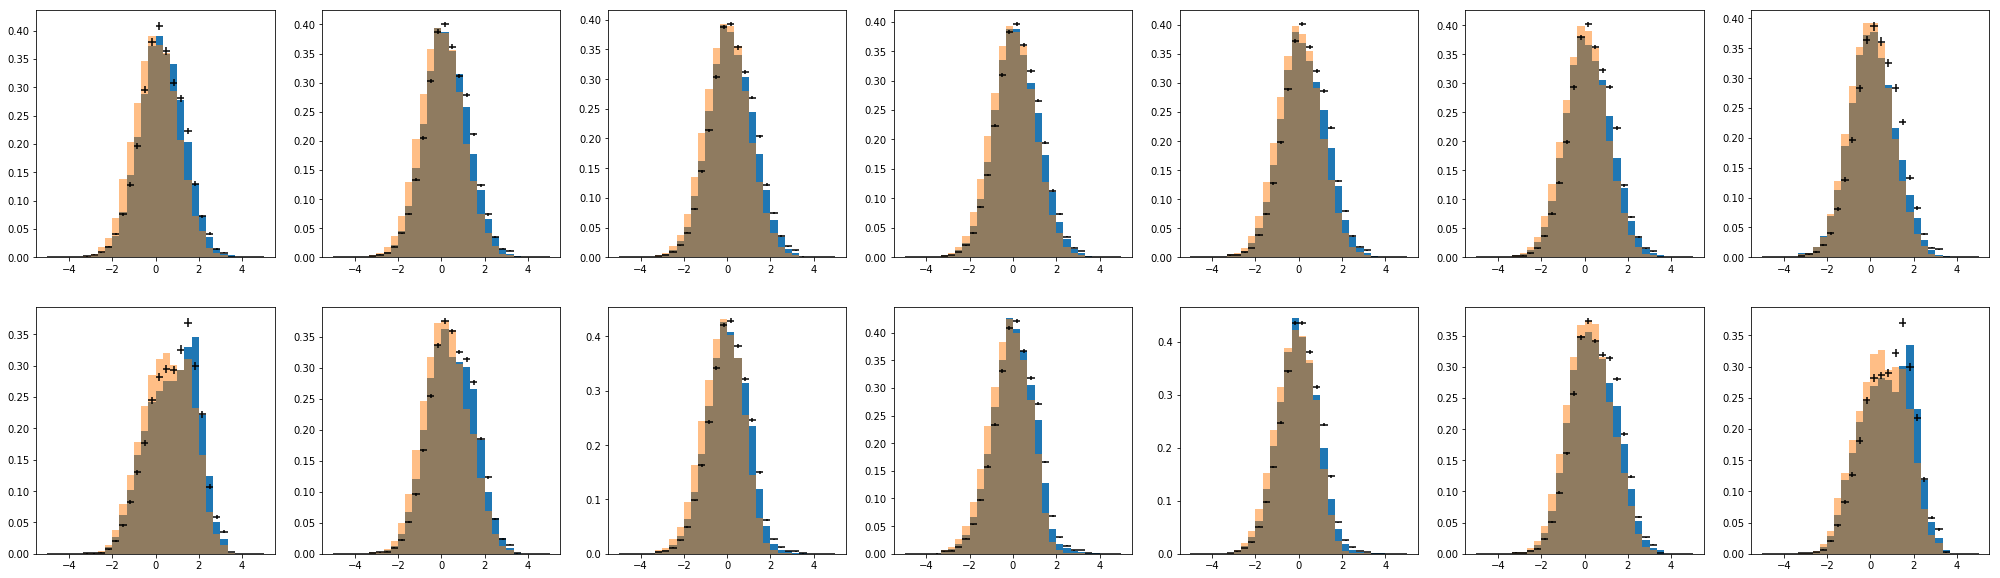

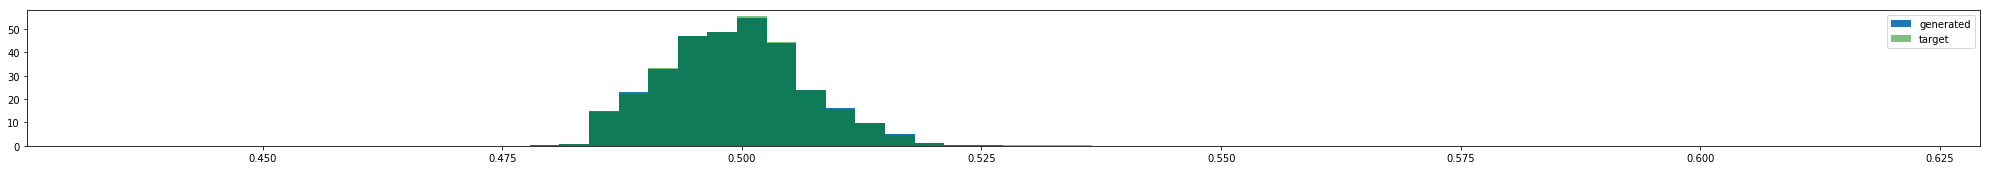

1314015/1314015 [==============================] - 71s - loss: 2.7733 - generator_loss: 1.3872 - generator_model_2_loss: 0.6935 - generator_D_256x5_output_loss: 0.6937 - discriminator_loss: 1.3861 - discriminator_model_2_loss: 0.6931 - discriminator_D_256x5_output_loss: 0.6929    
Epoch 12/60
1314015/1314015 [==============================] - 22s - loss: 2.7732 - generator_loss: 1.3872 - generator_model_2_loss: 0.6936 - generator_D_256x5_output_loss: 0.6935 - discriminator_loss: 1.3861 - discriminator_model_2_loss: 0.6930 - discriminator_D_256x5_output_loss: 0.6931      ETA: 11s - loss: 2.7733 - generator_loss: 
Epoch 13/60
1314015/1314015 [==============================] - 22s - loss: 2.7732 - generator_loss: 1.3871 - generator_model_2_loss: 0.6936 - generator_D_256x5_output_loss: 0.6935 - discriminator_loss: 1.3861 - discriminator_model_2_loss: 0.6930 - discriminator_D_256x5_output_loss: 0.6931    
Epoch 14/60
1314015/1314015 [==============================] - 22s - loss: 2.7732 - ge

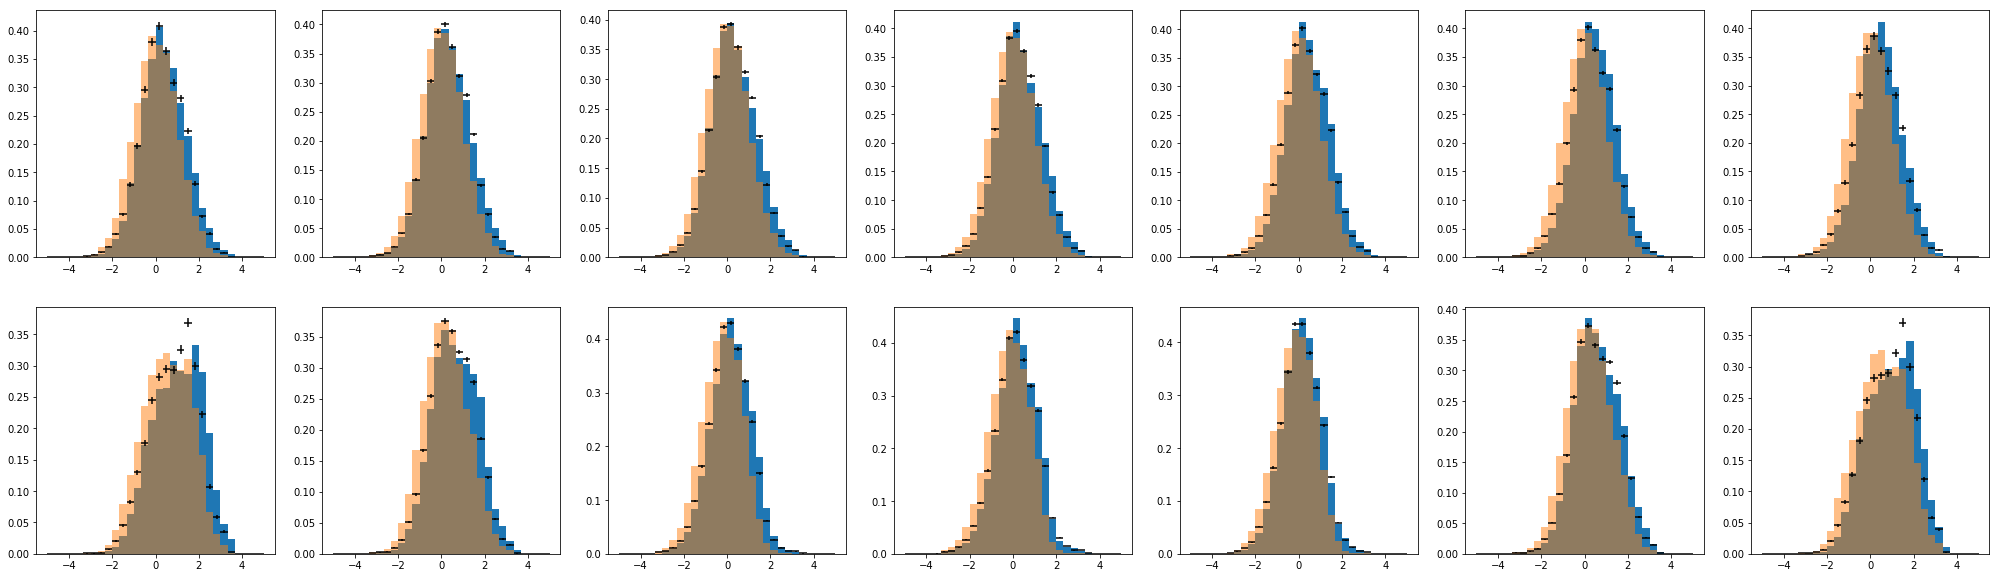

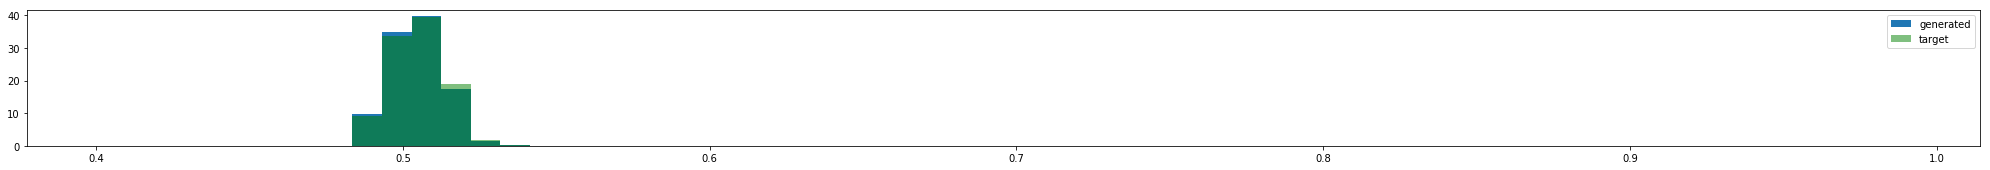

1314015/1314015 [==============================] - 75s - loss: 2.7734 - generator_loss: 1.3874 - generator_model_2_loss: 0.6936 - generator_D_256x5_output_loss: 0.6938 - discriminator_loss: 1.3860 - discriminator_model_2_loss: 0.6931 - discriminator_D_256x5_output_loss: 0.6930    
Epoch 22/60
1314015/1314015 [==============================] - 20s - loss: 2.7734 - generator_loss: 1.3874 - generator_model_2_loss: 0.6935 - generator_D_256x5_output_loss: 0.6938 - discriminator_loss: 1.3860 - discriminator_model_2_loss: 0.6931 - discriminator_D_256x5_output_loss: 0.6930    
Epoch 23/60
1314015/1314015 [==============================] - 20s - loss: 2.7734 - generator_loss: 1.3874 - generator_model_2_loss: 0.6936 - generator_D_256x5_output_loss: 0.6937 - discriminator_loss: 1.3860 - discriminator_model_2_loss: 0.6930 - discriminator_D_256x5_output_loss: 0.6930    
Epoch 24/60
1314015/1314015 [==============================] - 17s - loss: 2.7735 - generator_loss: 1.3874 - generator_model_2_los

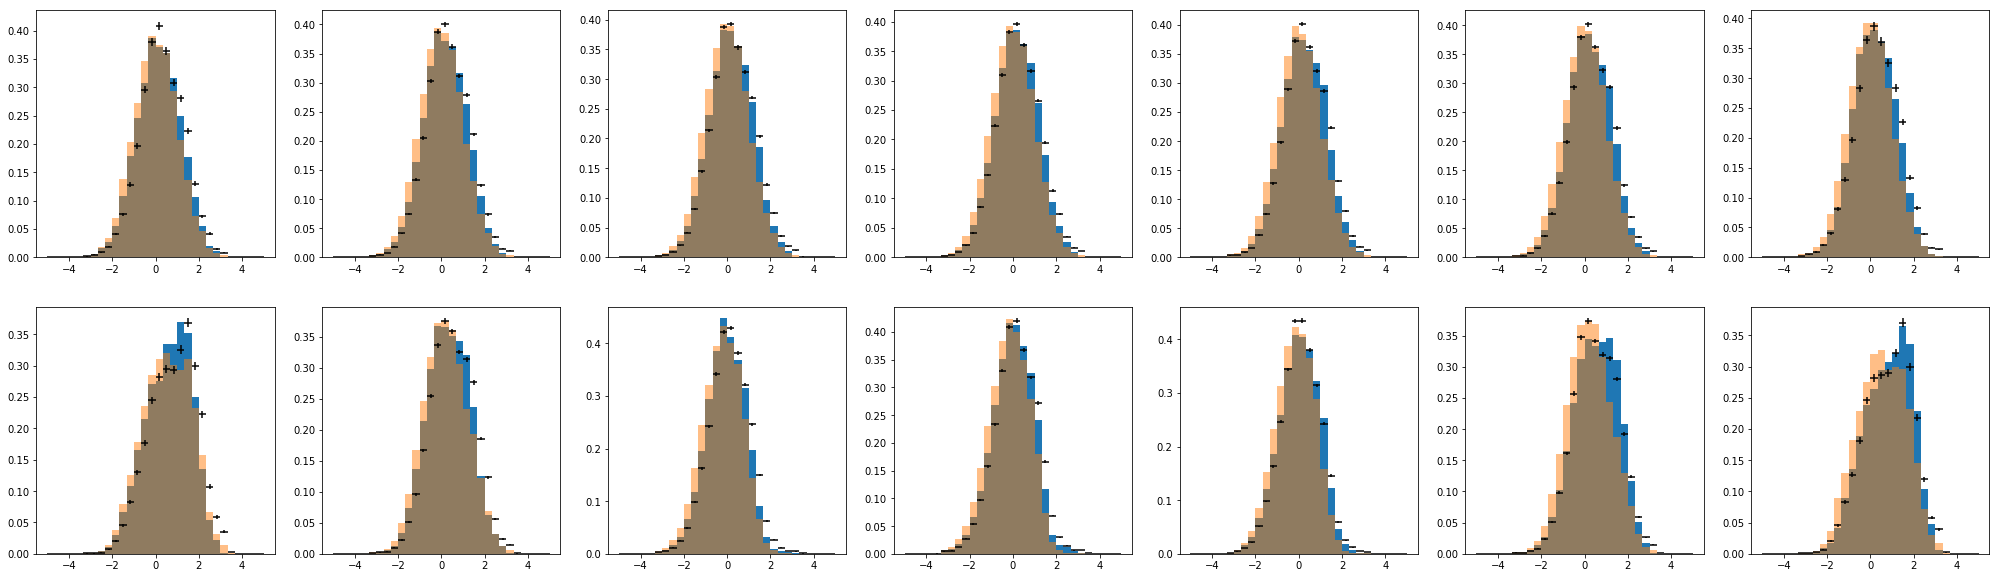

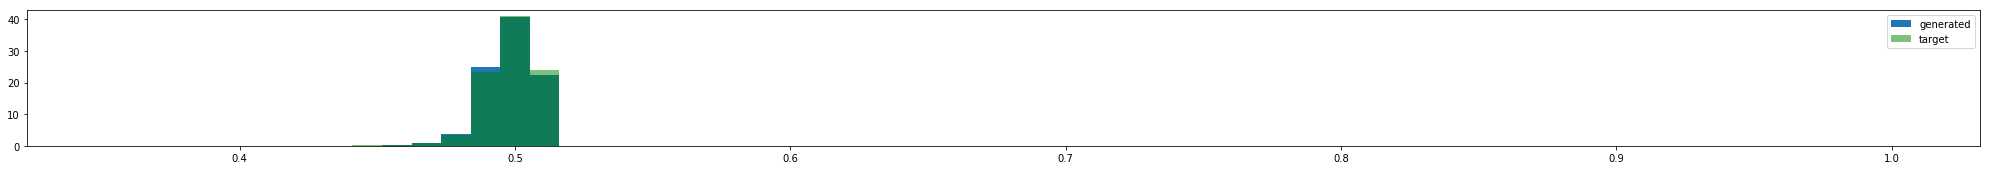

1314015/1314015 [==============================] - 73s - loss: 2.7736 - generator_loss: 1.3875 - generator_model_2_loss: 0.6937 - generator_D_256x5_output_loss: 0.6938 - discriminator_loss: 1.3860 - discriminator_model_2_loss: 0.6930 - discriminator_D_256x5_output_loss: 0.6931    
Epoch 32/60
1314015/1314015 [==============================] - 21s - loss: 2.7737 - generator_loss: 1.3876 - generator_model_2_loss: 0.6939 - generator_D_256x5_output_loss: 0.6938 - discriminator_loss: 1.3860 - discriminator_model_2_loss: 0.6928 - discriminator_D_256x5_output_loss: 0.6932    
Epoch 33/60
1314015/1314015 [==============================] - 20s - loss: 2.7735 - generator_loss: 1.3875 - generator_model_2_loss: 0.6936 - generator_D_256x5_output_loss: 0.6939 - discriminator_loss: 1.3860 - discriminator_model_2_loss: 0.6931 - discriminator_D_256x5_output_loss: 0.6930    
Epoch 34/60
1314015/1314015 [==============================] - 17s - loss: 2.7736 - generator_loss: 1.3875 - generator_model_2_los

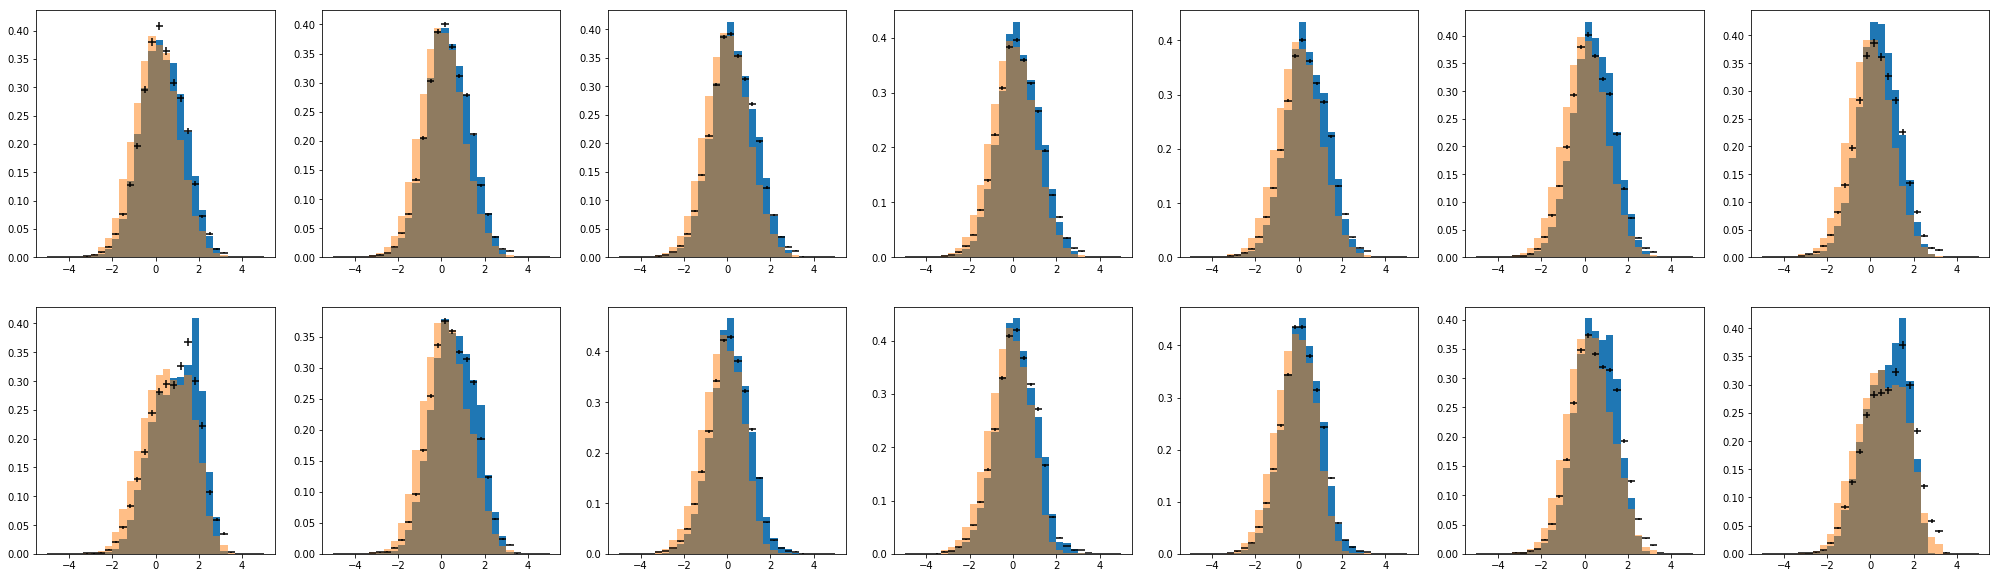

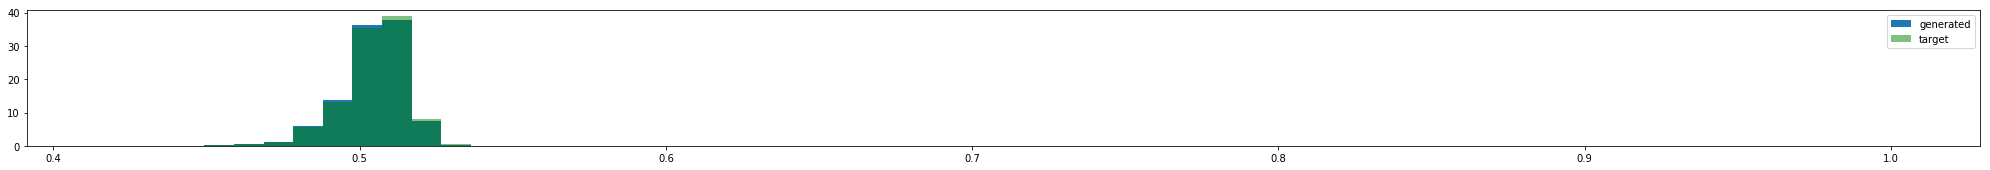

1314015/1314015 [==============================] - 75s - loss: 2.7737 - generator_loss: 1.3877 - generator_model_2_loss: 0.6938 - generator_D_256x5_output_loss: 0.6939 - discriminator_loss: 1.3860 - discriminator_model_2_loss: 0.6929 - discriminator_D_256x5_output_loss: 0.6931    
Epoch 42/60
1314015/1314015 [==============================] - 27s - loss: 2.7738 - generator_loss: 1.3878 - generator_model_2_loss: 0.6936 - generator_D_256x5_output_loss: 0.6942 - discriminator_loss: 1.3860 - discriminator_model_2_loss: 0.6931 - discriminator_D_256x5_output_loss: 0.6929    
Epoch 43/60
1314015/1314015 [==============================] - 19s - loss: 2.7738 - generator_loss: 1.3878 - generator_model_2_loss: 0.6937 - generator_D_256x5_output_loss: 0.6940 - discriminator_loss: 1.3860 - discriminator_model_2_loss: 0.6930 - discriminator_D_256x5_output_loss: 0.6931    
Epoch 44/60
1314015/1314015 [==============================] - 19s - loss: 2.7736 - generator_loss: 1.3875 - generator_model_2_los

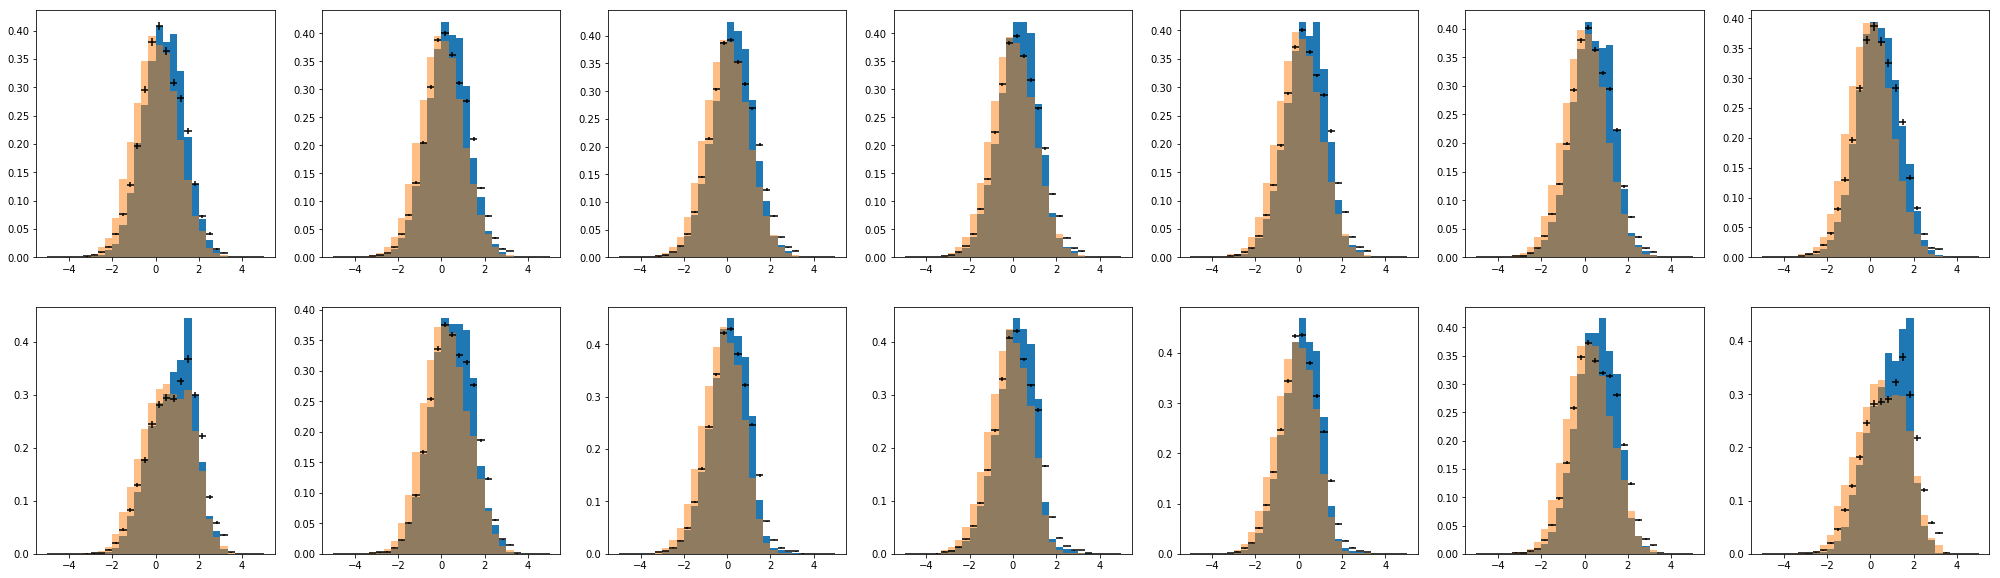

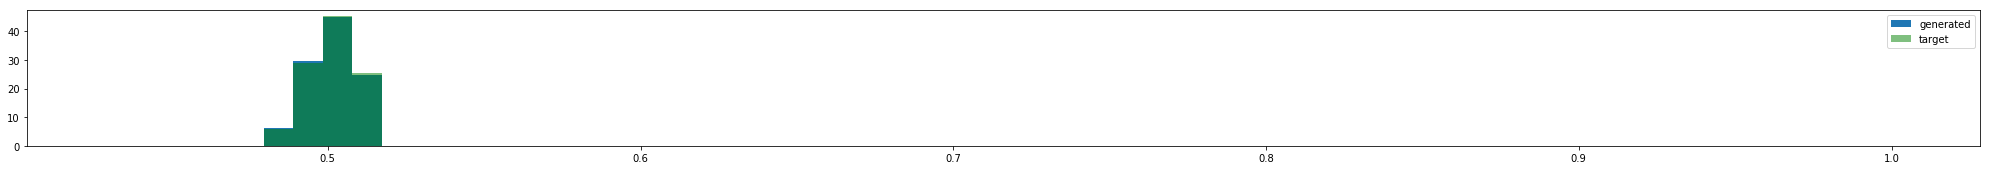

1314015/1314015 [==============================] - 78s - loss: 2.7734 - generator_loss: 1.3874 - generator_model_2_loss: 0.6937 - generator_D_256x5_output_loss: 0.6936 - discriminator_loss: 1.3861 - discriminator_model_2_loss: 0.6929 - discriminator_D_256x5_output_loss: 0.6931    
Epoch 52/60
1314015/1314015 [==============================] - 19s - loss: 2.7736 - generator_loss: 1.3875 - generator_model_2_loss: 0.6938 - generator_D_256x5_output_loss: 0.6938 - discriminator_loss: 1.3860 - discriminator_model_2_loss: 0.6929 - discriminator_D_256x5_output_loss: 0.6931    
Epoch 53/60
1314015/1314015 [==============================] - 24s - loss: 2.7735 - generator_loss: 1.3875 - generator_model_2_loss: 0.6936 - generator_D_256x5_output_loss: 0.6939 - discriminator_loss: 1.3860 - discriminator_model_2_loss: 0.6930 - discriminator_D_256x5_output_loss: 0.6930    
Epoch 54/60
1314015/1314015 [==============================] - 24s - loss: 2.7736 - generator_loss: 1.3875 - generator_model_2_los

In [26]:
reload(base)

do = dict(
    x_train=data_x_train,
    z_train=mc_x_train,
    c_x_train=data_c_train,
    c_z_train=mc_c_train,
          
    x_test=data_x_test,
    z_test=mc_x_test,
    c_x_test=data_c_test,
    c_z_test=mc_c_test,
    
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    plot_every=PLOT_EVERY,
)

base.MyGAN.adversarial_fit(gan,**do)


In [27]:
mc_x_morphed = gan.get_generator().predict([mc_c_test,mc_x_test])[1]

data_p = gan.get_discriminator().predict([data_c_test,data_x_test])
mc_p   = gan.get_discriminator().predict([mc_c_test,mc_x_morphed])

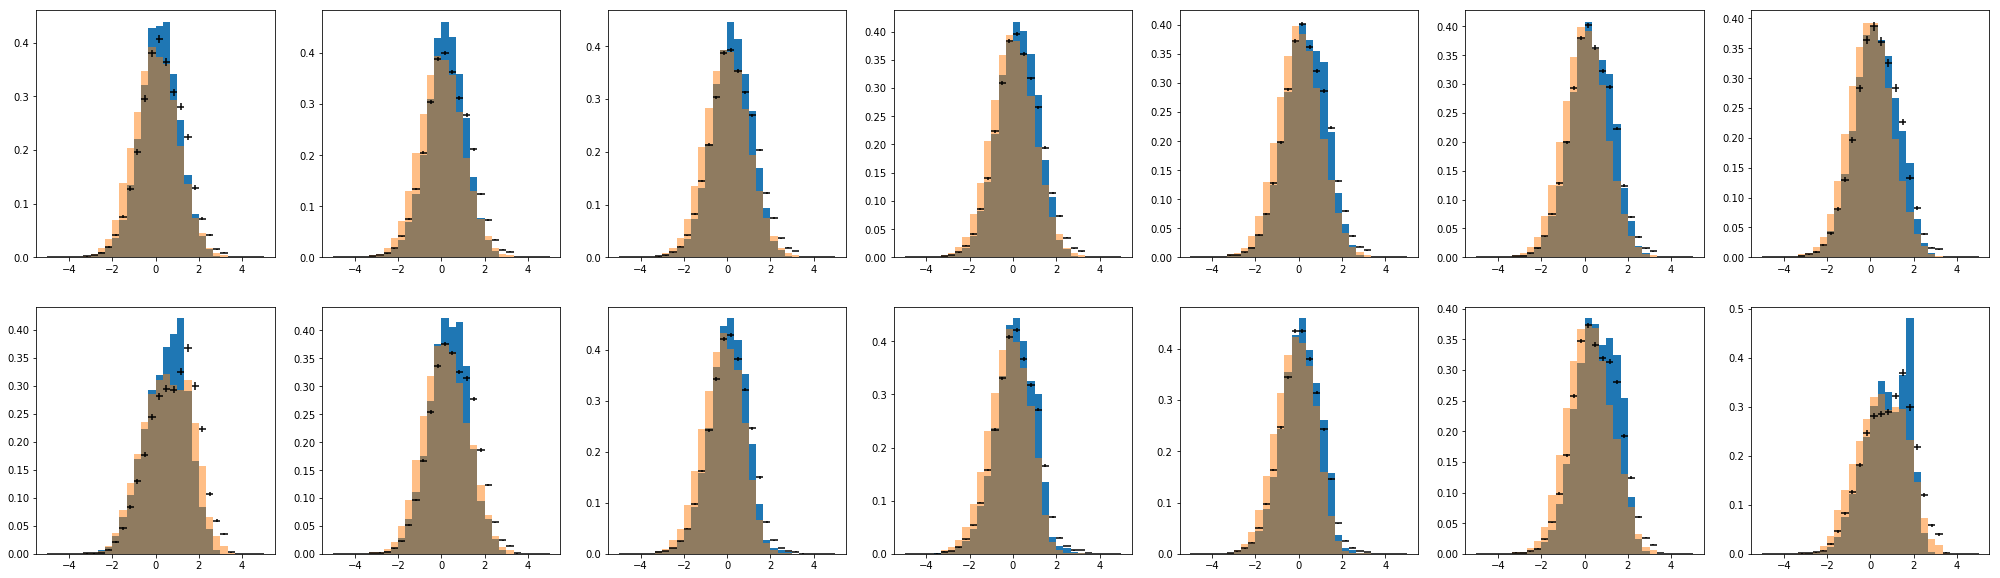

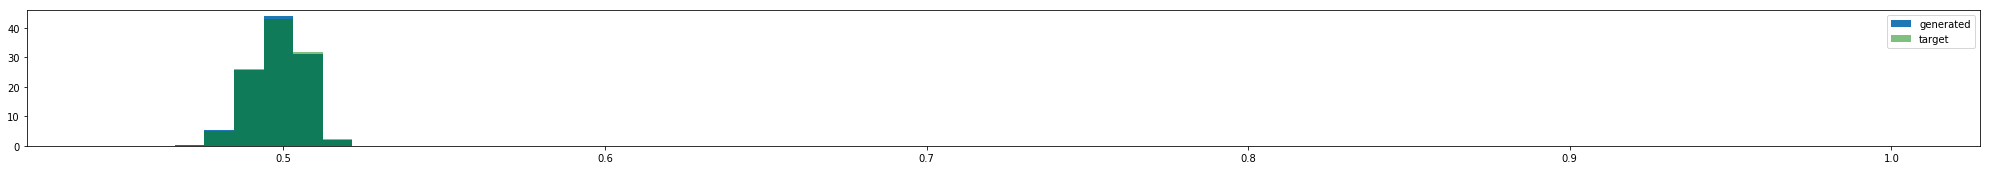

In [28]:
reload(plotting)

data_quantiles = np.percentile(data_c_test,[0,5,20,40,60,80,95,100])

# plotting.plot_summary_cond(data_x_test,data_c_test,mc_x_test,mc_c_test,mc_x_test,data_p,mc_p)
# plotting.plot_summary_cond(data_x_test,data_c_test,mc_x_morphed,mc_c_test,mc_x_test,data_p,mc_p)
plotting.plot_summary_cond(data_x_test,data_c_test,mc_x_morphed,mc_c_test,mc_x_test,data_p,mc_p,
                           do_slices=True,c_bounds=data_quantiles,saveas='gan_test1.png')
